In [ ]:
# # import matplotlib.pyplot as plt
# # import seaborn as sns
# # sns.set(style="darkgrid")

# import string
# import warnings
# warnings.filterwarnings('ignore')

# # Python ≥3.5 is required
# import sys
# assert sys.version_info >= (3, 5)

# # Scikit-Learn ≥0.20 is required
# import sklearn
# assert sklearn.__version__ >= "0.20"

# # Common imports
# import os
# import numpy as np
# import pandas as pd

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# # Make numpy values easier to read.
# np.set_printoptions(precision=3, suppress=True)

# # to make this notebook's output stable across runs
# np.random.seed(42)

# # To plot pretty figures
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

# # Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "ensembles"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

# SEED = 42

# **Setup**

[link text](https://)

In [ ]:
# Imports
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import string
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(keras.__version__)

2.6.0


In [ ]:
print(tf.__version__)

2.6.0


# **Import Data**

In [ ]:
dataframe = pd.read_csv("/content/drive/MyDrive/Data/titanic/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Data/titanic/test.csv")
dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
dataframe.shape

(891, 12)

**Define some functions to concatenate, as well as divide data, to help with preprocessing and feature engineering**

In [ ]:
# Concatenate df from train and test sets
def concat_df(train, test):
    return pd.concat([train, test], sort=True).reset_index(drop=True)

# Divides data back into train and test dfs
def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# Read Data
df_train = pd.read_csv("/content/drive/MyDrive/Data/titanic/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Data/titanic/test.csv")
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# **Handle Missing Values**

**Fairly strong correlation between Age and Pclass features**
- Filling missing values of Age with medians grouped by Sex and Pclass

In [ ]:
df_all_corr = df_all.corr().abs().unstack().sort_values(ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature A", "level_1": "Feature B", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature A'] == 'Age']

,Feature A,Feature B,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [ ]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


**Only two missing Emarked feature values.**
- Replacing with most common category seems reasonable

In [ ]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [ ]:
df_all['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [ ]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

**Only one record includes a missing Fare value**
- Since this person was a 3rd class passenger, we will replace this missing value with the median fare of a single 3rd class passenger.

In [ ]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [ ]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0] # for 3rd class, single passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

**Although there are quite a few missing values for Cabin, this feature may prove to be of some importance**
- Creating a Deck feature which groups Cabin ABC, DE, and FG
- Also, creating an M category for missing values

In [ ]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

# Drop Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

# Display New Category Counts
df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

## **Some Feature Engineering**

**Feature engineering for Numerics**

In [ ]:
# Age squared feature
df_all['Age_sq'] = df_all['Age']**2

# Age - Fare Interaction
df_all['Age_Fare_Int'] = df_all['Age'] * df_all['Fare']

# Family Size Feature
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

# Creating Travel Alone Feature 
df_all['Alone'] = df_all['Family_Size'].apply(lambda s: 1 if s < 2 else 0) 

**Creating Family Size categorical feature**

In [ ]:
family_dict = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_dict)

**Creating Ticket Frequency Feature**

In [ ]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

**Create categories from Titles**

In [ ]:
# Stripping title from name feature
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

# Married Feature
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

In [ ]:
# Grouping Titles
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev', 'the Countess'], 'Dr/Military/Noble/Clergy/Countess')

In [ ]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

**Dropping Name, Ticket, PassengerId Features**

In [ ]:
drop_cols = ['Name', 'Ticket', 'PassengerId']
df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Deck,Age_sq,Age_Fare_Int,Family_Size,Alone,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Family
0,22.0,S,7.2500,0,3,male,1,0.0,M,484.0,159.5000,2,0,Small,1,Mr,0,Braund
1,38.0,C,71.2833,0,1,female,1,1.0,ABC,1444.0,2708.7654,2,0,Small,2,Miss/Mrs/Ms,1,Cumings
2,26.0,S,7.9250,0,3,female,0,1.0,M,676.0,206.0500,1,1,Alone,1,Miss/Mrs/Ms,0,Heikkinen
3,35.0,S,53.1000,0,1,female,1,1.0,ABC,1225.0,1858.5000,2,0,Small,2,Miss/Mrs/Ms,1,Futrelle
4,35.0,S,8.0500,0,3,male,0,0.0,M,1225.0,281.7500,1,1,Alone,1,Mr,0,Allen


# **Prepping data for model**
- Redefining data types in preparation for model

In [ ]:
df_all['Embarked'] = df_all['Embarked'].astype('category')
df_all['Sex'] = df_all['Sex'].astype('category')

df_all['Embarked'] = df_all['Embarked'].cat.codes
df_all['Sex'] = df_all['Sex'].cat.codes

In [ ]:
df_all['Family_Size_Grouped'] = df_all['Family_Size_Grouped'].astype('string')
df_all['Title'] = df_all['Title'].astype('string')
df_all['Family'] = df_all['Family'].astype('string')
df_all['Deck'] = df_all['Deck'].astype('string')

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1309 non-null   float64
 1   Embarked             1309 non-null   int8   
 2   Fare                 1309 non-null   float64
 3   Parch                1309 non-null   int64  
 4   Pclass               1309 non-null   int64  
 5   Sex                  1309 non-null   int8   
 6   SibSp                1309 non-null   int64  
 7   Survived             891 non-null    float64
 8   Deck                 1309 non-null   string 
 9   Age_sq               1309 non-null   float64
 10  Age_Fare_Int         1309 non-null   float64
 11  Family_Size          1309 non-null   int64  
 12  Alone                1309 non-null   int64  
 13  Family_Size_Grouped  1309 non-null   string 
 14  Ticket_Frequency     1309 non-null   int64  
 15  Title                1309 non-null   s

In [ ]:
# Displaying the datatypes
display(df_all.dtypes)

# converting Features from float to int
dataframe = df_all.astype({"Age":'int', "Embarked": 'int', "Sex":'int', "Age_sq":'int',
                           "Age_Fare_Int":'int'})

# displaying the datatypes
display(dataframe.dtypes)

Age                    float64
Embarked                  int8
Fare                   float64
Parch                    int64
Pclass                   int64
Sex                       int8
SibSp                    int64
Survived               float64
Deck                    string
Age_sq                 float64
Age_Fare_Int           float64
Family_Size              int64
Alone                    int64
Family_Size_Grouped     string
Ticket_Frequency         int64
Title                   string
Is_Married               int64
Family                  string
dtype: object

Age                      int64
Embarked                 int64
Fare                   float64
Parch                    int64
Pclass                   int64
Sex                      int64
SibSp                    int64
Survived               float64
Deck                    string
Age_sq                   int64
Age_Fare_Int             int64
Family_Size              int64
Alone                    int64
Family_Size_Grouped     string
Ticket_Frequency         int64
Title                   string
Is_Married               int64
Family                  string
dtype: object

In [ ]:
dataframe, df_test = divide_df(dataframe)
# dfs = [dataframe, df_test]

In [ ]:
val_dataframe = dataframe.sample(frac=0.2, random_state=10)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 713 samples for training and 178 for validation


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Survived")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Age': <tf.Tensor: shape=(), dtype=int64, numpy=19>, 'Embarked': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'Fare': <tf.Tensor: shape=(), dtype=float64, numpy=7.8958>, 'Parch': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Pclass': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'Sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'SibSp': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Deck': <tf.Tensor: shape=(), dtype=string, numpy=b'M'>, 'Age_sq': <tf.Tensor: shape=(), dtype=int64, numpy=361>, 'Age_Fare_Int': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'Family_Size': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'Alone': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'Family_Size_Grouped': <tf.Tensor: shape=(), dtype=string, numpy=b'Alone'>, 'Ticket_Frequency': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'Title': <tf.Tensor: shape=(), dtype=string, numpy=b'Mr'>, 'Is_Married': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'Family': <tf.Tensor: shape=(), dtype=string, numpy=b'Pet

In [ ]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

# **Feature Preprocessing**

**1. The following are categorical features encoded as integers:**
- Embarked 
- Pclass
- Sex
- Alone
- Is_Married

**I will encode these features using one-hot encoding. We have two options here:**

- Use **`CategoryEncoding()`**, which requires knowing the range of input values and will error on input outside the range.

- Use **`IntegerLookup()`** which will build a lookup table for inputs and reserve an output index for unkown input values.

*I'll use IntegerLookup(); it will allow the easy handling of out of range inputs during inference.*


**2. We also have a categorical feature encoded as a string:** 
- Family_Size_grouped, Title, Deck and Family. 
- We will create an index of all possible features and encode output using the `StringLookup()` layer.

**3. Finally, the following feature are continuous numerical features:**

- Age
- Fare
- Parch
- SibSp
- Age_sq
- Age_Fare_Int
- Family_Size
- Ticket_Frequency

**For each of these features, we will use a `Normalization()` layer to make sure the mean of each feature is 0 and its standard deviation is 1.**


**Below, we define 3 utility functions to do the operations:**

- **`encode_numerical_feature`** to apply featurewise normalization to numerical features.
- **`encode_string_categorical_feature`** to first turn string inputs into integer indices, then one-hot encode these integer indices.
- **`encode_integer_categorical_feature`** to one-hot encode integer categorical features.


In [ ]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

# **Full Model**


In [ ]:
# allows us to create a wrapper for any callable
# will use for Dense layers
from functools import partial

In [ ]:
tf.keras.backend.clear_session() # Resets all keras states

tf.random.set_seed(45)

# Categorical features encoded as integers
embarked = keras.Input(shape=(1,), name="Embarked", dtype="int64")
pclass = keras.Input(shape=(1,), name="Pclass", dtype="int64")
sex = keras.Input(shape=(1,), name="Sex", dtype="int64")
alone = keras.Input(shape=(1,), name="Alone", dtype="int64")
is_married = keras.Input(shape=(1,), name="Is_Married", dtype="int64")

# Categorical feature encoded as string
family_size_group = keras.Input(shape=(1,), name="Family_Size_Grouped", dtype="string")
title = keras.Input(shape=(1,), name="Title", dtype="string")
family = keras.Input(shape=(1,), name="Family", dtype="string")
deck = keras.Input(shape=(1,), name="Deck", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="Age")
fare = keras.Input(shape=(1,), name="Fare")
parch = keras.Input(shape=(1,), name="Parch")
sibsp = keras.Input(shape=(1,), name="SibSp")
age_sq = keras.Input(shape=(1,), name="Age_sq")
age_fare_int = keras.Input(shape=(1,), name="Age_Fare_Int")
family_size = keras.Input(shape=(1,), name="Family_Size")
ticket_frequency = keras.Input(shape=(1,), name="Ticket_Frequency")

all_inputs = [
    embarked,
    pclass,
    sex,
    alone,
    is_married,
    family_size_group,
    title,
    family,
    deck,
    age,
    fare,
    parch,
    sibsp,
    age_sq,
    age_fare_int,
    family_size,
    ticket_frequency
]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "Sex", train_ds, False)
embarked_encoded = encode_categorical_feature(embarked, "Embarked", train_ds, False)
pclass_encoded = encode_categorical_feature(pclass, "Pclass", train_ds, False)
alone_encoded = encode_categorical_feature(alone, "Alone", train_ds, False)
is_married = encode_categorical_feature(is_married, "Is_Married", train_ds, False)

# String categorical features
family_size_group_encoded = encode_categorical_feature(family_size_group, "Family_Size_Grouped", train_ds, True)
title_encoded = encode_categorical_feature(title, "Title", train_ds, True)
family_encoded = encode_categorical_feature(family, "Family", train_ds, True)
deck_encoded = encode_categorical_feature(deck, "Deck", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "Age", train_ds)
fare_encoded = encode_numerical_feature(fare, "Fare", train_ds)
parch_encoded = encode_numerical_feature(parch, "Parch", train_ds)
sibsp_encoded = encode_numerical_feature(sibsp, "SibSp", train_ds)
age_sq_encoded = encode_numerical_feature(age_sq, "Age_sq", train_ds)
age_fare_int_encoded = encode_numerical_feature(age_fare_int, "Age_Fare_Int", train_ds)
family_size_int_encoded = encode_numerical_feature(family_size, "Family_Size", train_ds)
ticket_frequency_int_encoded = encode_numerical_feature(ticket_frequency, "Ticket_Frequency", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        embarked_encoded,
        pclass_encoded,
        alone_encoded,
        is_married,
        family_size_group_encoded,
        title_encoded,
        family_encoded,
        deck_encoded,
        age_encoded,
        fare_encoded,
        parch_encoded,
        sibsp_encoded,
        age_sq_encoded,
        age_fare_int_encoded,
        family_size_int_encoded,
        ticket_frequency_int_encoded
    ]
)


# Create thin wrapper for Dense layer
RegularizedDense = partial(keras.layers.Dense,
                           activation = "relu",
                           kernel_regularizer = keras.regularizers.l2(0.02))

# Model Structure
x = RegularizedDense(64)(all_features)
x = RegularizedDense(32)(x)
x = layers.Dropout(0.25)(x)
x = RegularizedDense(16)(x)
x = layers.Dropout(0.25)(x)
output = layers.Dense(1, activation="sigmoid")(x)


# Compile Model
model = keras.Model(all_inputs, output)
model.compile("nadam", "binary_crossentropy", metrics=["accuracy"])

## **Connectivity Chart**
- Show model structure

In [ ]:
StringLookup()

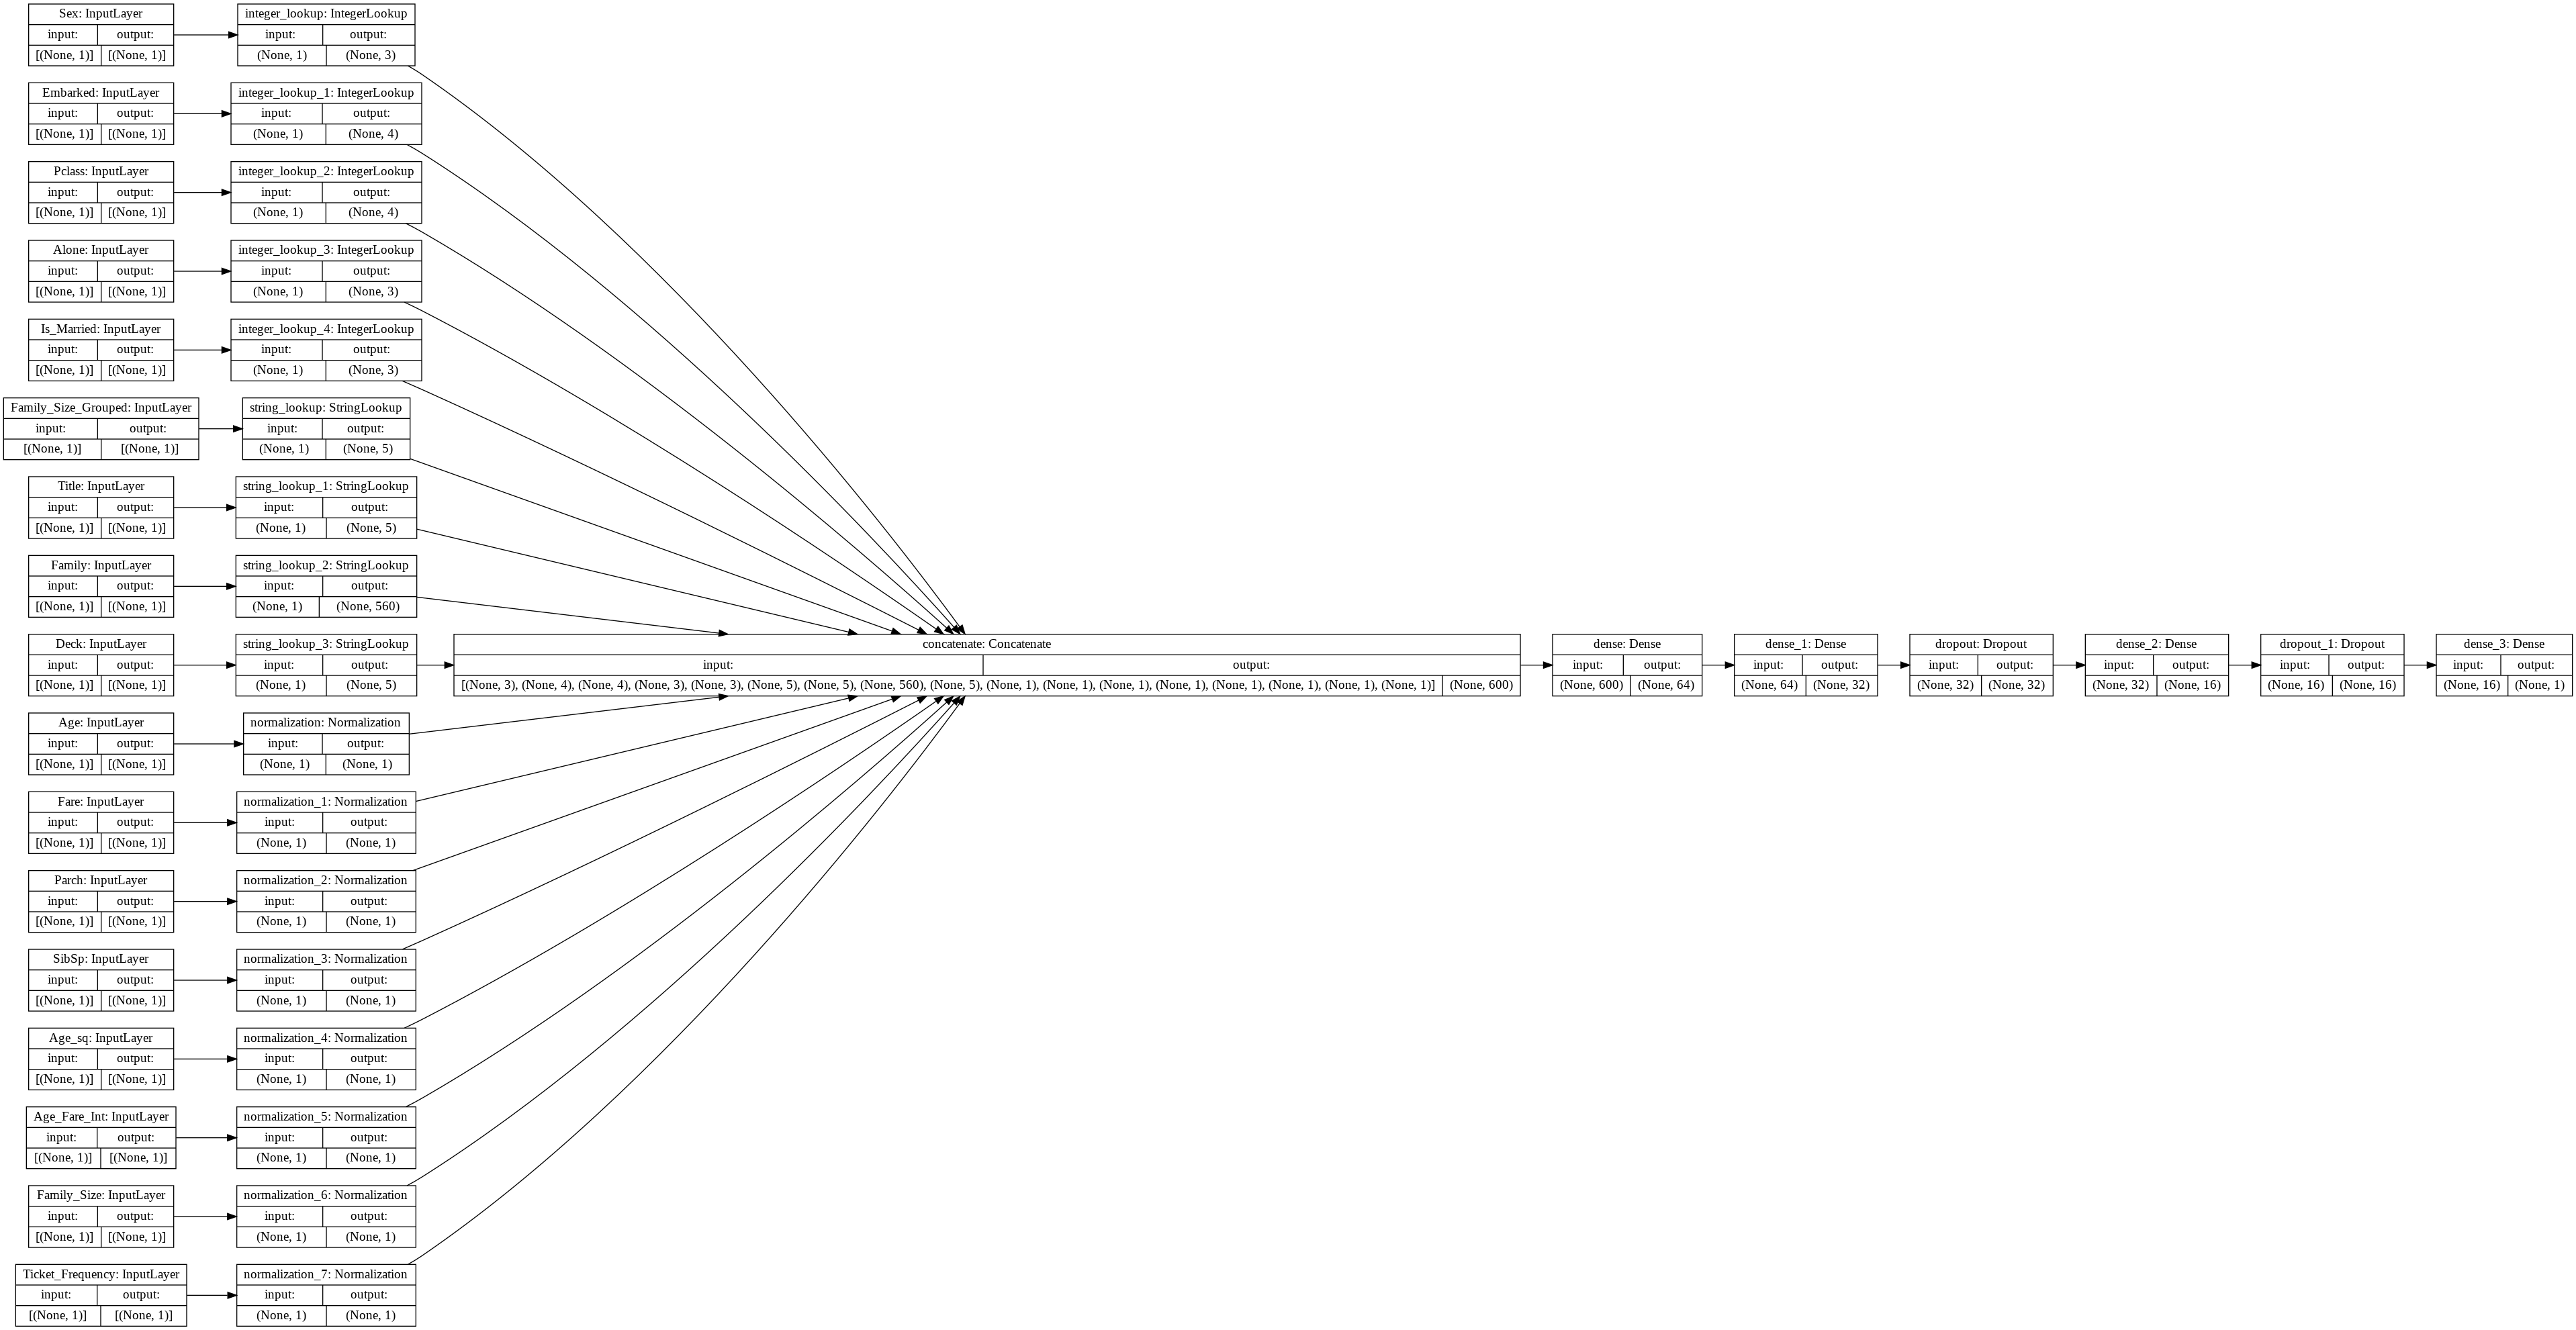

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# **Train Model**

In [ ]:
# Early Stopping Callback
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# Callback to control learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.20,
                              patience=2, min_lr=0.0009)

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[reduce_lr, es_callback])

Epoch 1/50
23/23 [==============================] - 2s 22ms/step - loss: 3.6233 - accuracy: 0.5414 - val_loss: 2.9147 - val_accuracy: 0.7753
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 2.4627 - accuracy: 0.6774 - val_loss: 1.9956 - val_accuracy: 0.7978
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 1.7491 - accuracy: 0.7195 - val_loss: 1.4503 - val_accuracy: 0.8090
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 1.3261 - accuracy: 0.7616 - val_loss: 1.1131 - val_accuracy: 0.8371
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 1.0717 - accuracy: 0.7854 - val_loss: 0.9161 - val_accuracy: 0.8483
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.9191 - accuracy: 0.8036 - val_loss: 0.8080 - val_accuracy: 0.8596
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.8238 - accuracy: 0.8107 - val_loss: 0.7086 - val_accuracy: 0.8427
Epoch 8/50
23/23 [=

In [ ]:
model.evaluate(x = val_ds)

6/6 [==============================] - 0s 3ms/step - loss: 0.4423 - accuracy: 0.8483


[0.4422645568847656, 0.8483145833015442]

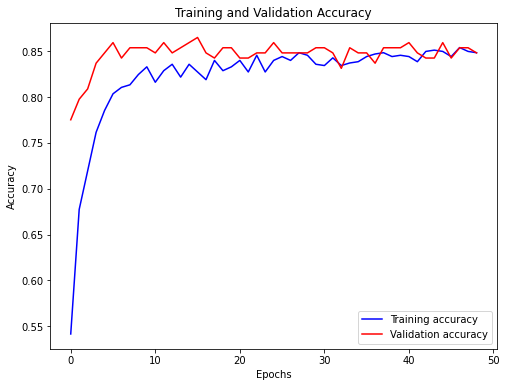

In [ ]:
def visualize_accuracy(history, title):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(accuracy))
    plt.figure(figsize=(8,6))
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


visualize_accuracy(history, "Training and Validation Accuracy")

# **Inference on new data**

**Making a prediction on a new record by calling `model.predict()`. First I have to:**

- Wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
- Call `convert_to_tensor` on each feature

In [ ]:
df_test.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Deck,Age_sq,Age_Fare_Int,Family_Size,Alone,Family_Size_Grouped,Ticket_Frequency,Title,Is_Married,Family
891,34,1,7.8292,0,3,1,0,M,1190,270,1,1,Alone,1,Mr,0,Kelly
892,47,2,7.0000,0,3,0,1,M,2209,329,2,0,Small,1,Miss/Mrs/Ms,1,Wilkes
893,62,1,9.6875,0,2,1,0,M,3844,600,1,1,Alone,1,Mr,0,Myles
894,27,2,8.6625,0,3,1,0,M,729,233,1,1,Alone,1,Mr,0,Wirz
895,22,2,12.2875,1,3,0,1,M,484,270,3,0,Small,2,Miss/Mrs/Ms,1,Hirvonen


**Using the first record in the test set**

In [ ]:
# Create a dictionary for the record
sample = {
    "Age": 34,
    "Embarked": 1,
    "Fare": 7.8292,
    "Parch": 0,
    "Pclass": 3,
    "Sex": 1,
    "SibSp": 0,
    "Deck": "M",
    "Age_sq": 1190,
    "Age_Fare_Int": 270,
    "Family_Size": 1,
    "Alone": 1,
    "Family_Size_Grouped": "Alone",
    "Ticket_Frequency": 1,
    "Title": "Mr",
    "Is_Married": 0,
    "Family": "Kelly",
}

# Convert to tensor
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This person had a %.1f percent probability "
    "of surviving, as evaluated by our model." % (100 * predictions[0][0],)
)

This person had a 14.3 percent probability of surviving, as evaluated by our model.


In [ ]:
X_test_features_dict = {name: np.array(value) 
                         for name, value in df_test.items()}

**This displays the probabilities of survival for each record in the test set as evaluated by our model:**

In [ ]:
target_prob = model.predict(X_test_features_dict)
target_prob[:10]

array([[0.14311895],
       [0.37991995],
       [0.1546123 ],
       [0.1348024 ],
       [0.6342572 ],
       [0.1429654 ],
       [0.65695775],
       [0.1536035 ],
       [0.84323704],
       [0.1239278 ]], dtype=float32)

**Define a function to convert probabilities into survival class with 0.5 cutoff**
- 1 = Survived
- 0 = Not Survived

In [ ]:
def BinaryPredictionDF(probs):
  prediction = []

  for prob in probs: 
    if prob > 0.5:
      prediction.append(1)
    else:
      prediction.append(0)
  return(pd.DataFrame(prediction, columns = ['Survived']))

In [ ]:
BinaryPredictionDF(target_prob)

,Survived
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


**Add PassengerID column to our new Dataframe**

In [ ]:
submission = BinaryPredictionDF(target_prob)
submission['PassengerId'] = test_data['PassengerId']

In [ ]:
# Checking the predicted survival distribution
submission['Survived'].value_counts() / 418

0    0.629187
1    0.370813
Name: Survived, dtype: float64

# **Plot of Predicted Survival Rates**

Our model predicts that 155 of 418 passengers survived or 37.08% of the test set.
Our model predicts that 263 of 418 passengers did not survive or 62.92% of the test set.


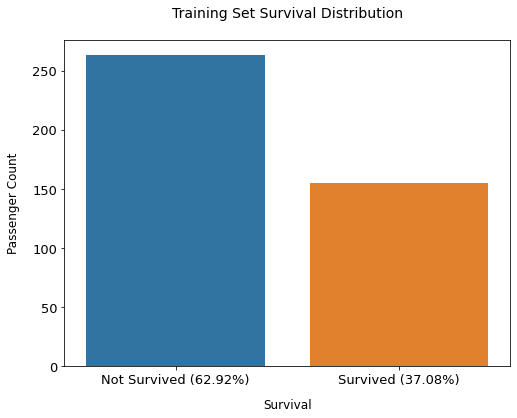

In [ ]:
survived = submission['Survived'].value_counts()[1]
not_survived = submission['Survived'].value_counts()[0]
survived_per = survived / submission.shape[0] * 100
not_survived_per = not_survived / submission.shape[0] * 100

print('Our model predicts that {} of {} passengers survived or {:.2f}% of the test set.'.format(survived, submission.shape[0], survived_per))
print('Our model predicts that {} of {} passengers did not survive or {:.2f}% of the test set.'.format(not_survived, submission.shape[0], not_survived_per))

plt.figure(figsize=(8, 6))
sns.countplot(submission['Survived'])

plt.xlabel('Survival', size=12, labelpad=12)
plt.ylabel('Passenger Count', size=12, labelpad=12)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=14, y=1.05)

plt.show()

**Rearrange PassengerID and Survived Columns**

In [ ]:
cols = list(submission)
cols[1], cols[0] = cols[0], cols[1]
cols

['PassengerId', 'Survived']

In [ ]:
submission = submission.loc[:, cols]

In [ ]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
submission.to_csv("submission.csv", index=False)